<a href="https://colab.research.google.com/github/ricardokj/GCloud_Colab_Kaggle/blob/main/Colab_GCP_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Cloud Platform + Colab + Kaggle

## Inicialização de pacotes e variáveis

In [ ]:
from google.cloud import storage
from google.colab import auth
from google.cloud import bigquery
from random import randrange
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


color = sns.color_palette()
start_time = time.time()
project_id='gcp-colab-292521'
bucket_name='gcp-colab-bucket'
dataset='gcp_colab_lake'
proj_dir=os.getcwd()
arq_dir=proj_dir+'/arquivos'
compet_kaggle="instacart-market-basket-analysis"
auth.authenticate_user()
client = bigquery.Client(project=project_id)
storage_client = storage.Client(project=project_id)

## Download da competição e unzip

In [ ]:
%%capture
!mkdir -p {arq_dir} 
!kaggle competitions download -o -q -c {compet_kaggle} -p {arq_dir} 
!cd {arq_dir} && unzip -u "*zip" && rm -rf *.zip __MACOSX >/dev/null

## Envio dos arquivos com paralelismo para Google Cloud Storage (680mb em 10 segundos)

In [ ]:
%time !gsutil -m -o GSUtil:parallel_composite_upload_threshold=200M  cp {arq_dir}/*.csv gs://{bucket_name}/gcp-csv/

Copying file:///content/arquivos/aisles.csv [Content-Type=text/csv]...
Copying file:///content/arquivos/departments.csv [Content-Type=text/csv]...
Copying file:///content/arquivos/order_products__prior.csv [Content-Type=text/csv]...
Copying file:///content/arquivos/products.csv [Content-Type=text/csv]...
Copying file:///content/arquivos/order_products__train.csv [Content-Type=text/csv]...
Copying file:///content/arquivos/orders.csv [Content-Type=text/csv]...
Copying file:///content/arquivos/sample_submission.csv [Content-Type=text/csv]...
| [7/7 files][681.7 MiB/681.7 MiB] 100% Done                                    
Operation completed over 7 objects/681.7 MiB.                                    
CPU times: user 38 ms, sys: 18.2 ms, total: 56.2 ms
Wall time: 9.03 s


## Funções Python - Google Cloud Storage e Google BigQuery

In [ ]:
def upload_bigquery(proj_id,dataset,tabela,arq_origem,formato):
    !bq load --autodetect --replace --source_format={formato} --project_id {proj_id} {dataset}.{tabela} {arq_origem}

def call_upload_bigquery(origem):
    if origem == 'vm':
      files = [f for f in os.listdir(arq_dir) ]
      for f in files:
        if 'csv' in f:
          tab=f[0:f.index('.csv')]
          arq=arq_dir+'/'+f
          print('Envio de arquivo da vm para BigQuery: '+tab)
          upload_bigquery(project_id,dataset,tab,arq,'CSV')
                
    elif origem == 'gstore':
        blobs = storage_client.list_blobs(bucket_name)
        for blob in blobs:
            arq=blob.name
            if '.csv' in arq:
                tab=arq[arq.index('/')+1:arq.index('.csv')]
                arq='gs://'+bucket_name+'/'+arq
                print('Envio de arquivo do gstore para BigQuery: '+tab)
                upload_bigquery(project_id,dataset,tab,arq,'CSV') 

## Upload dos arquivos da VM para Big Query ~ 2:20 min

In [ ]:
##%time call_upload_bigquery('vm')

## Upload dos arquivos da Cloud Storage para Big Query ~ 2 min

In [ ]:
%time call_upload_bigquery('gstore')
print("--- %s seconds ---" % (time.time() - start_time))

Envio de arquivo do gstore para BigQuery: aisles

Welcome to BigQuery! This script will walk you through the 
process of initializing your .bigqueryrc configuration file.

First, we need to set up your credentials if they do not 
already exist.

Credential creation complete. Now we will select a default project.

List of projects:
  #            projectId               friendlyName    
 --- ------------------------------ ------------------ 
  1   gcp-colab-292521               gcp-colab         
  2   project--1575178859540344146   AppGoogleLogin    
  3   project-44278132489095088      AppLoginGoogle    
  4   gothic-isotope-292519          My First Project  
  5   probable-byway-292520          My First Project  
Found multiple projects. Please enter a selection for 
which should be the default, or leave blank to not 
set a default.

Enter a selection (1 - 5): 1

BigQuery configuration complete! Type "bq" to get started.

Waiting on bqjob_r62f7dadb029820c2_00000175494524ef_1 ... (1s)

## Comandos SQL via BigQuery magic commands

In [ ]:
%%bigquery --project {project_id}
select table_id,
  CAST(TIMESTAMP_MILLIS(last_modified_time - 3600000*3) AS DATETIME) as modate,
  CAST(TIMESTAMP_MILLIS(creation_time - 3600000*3) AS DATETIME) as crdate,
  round(size_bytes/1024/1024,2) as mb,row_count
from gcp_colab_lake.__TABLES__ order by mb desc; 

,table_id,modate,crdate,mb,row_count
0,order_products__prior,2020-10-21 00:48:39.401,2020-10-17 17:35:44.455,989.82,32434489
1,orders,2020-10-21 00:49:19.617,2020-10-17 17:36:23.391,177.80,3421083
2,order_products__train,2020-10-21 00:48:53.099,2020-10-17 17:34:55.592,42.26,1384617
3,products,2020-10-21 00:49:33.118,2020-10-17 17:36:36.753,2.69,49688
4,sample_submission,2020-10-21 00:49:37.152,2020-10-17 17:36:01.542,1.50,75000
5,aisles,2020-10-21 00:47:51.380,2020-10-17 17:35:57.699,0.00,134
6,departments,2020-10-21 00:47:54.927,2020-10-17 17:36:32.207,0.00,21


## Criação da tabela de vendas por produto

In [ ]:
%%bigquery --project {project_id}
    create or replace table gcp_colab_dw.sales_product
    as select distinct 
      a.product_id, a.product_name,c.aisle,d.department,
      count(b.product_id) as sale_count, sum(b.reordered) as sale_reorder
    from gcp_colab_lake.products a 
    left join gcp_colab_lake.order_products__prior b on a.product_id = b. product_id 
    left join gcp_colab_lake.aisles c on a.aisle_id=c.aisle_id
    left join gcp_colab_lake.departments d on a.department_id = d.department_id
    group by 1,2,3,4
  order by sale_count desc;

  select * from gcp_colab_dw.sales_product limit 10;

,product_id,product_name,aisle,department,sale_count,sale_reorder
0,24852,Banana,fresh fruits,produce,472565,398609
1,13176,Bag of Organic Bananas,fresh fruits,produce,379450,315913
2,21137,Organic Strawberries,fresh fruits,produce,264683,205845
3,21903,Organic Baby Spinach,packaged vegetables fruits,produce,241921,186884
4,47209,Organic Hass Avocado,fresh fruits,produce,213584,170131
5,47766,Organic Avocado,fresh fruits,produce,176815,134044
6,47626,Large Lemon,fresh fruits,produce,152657,106255
7,16797,Strawberries,fresh fruits,produce,142951,99802
8,26209,Limes,fresh fruits,produce,140627,95768
9,27845,Organic Whole Milk,milk,dairy eggs,137905,114510


## Criação da tabela orders_data com os campos order_date e week_number

In [ ]:
%%bigquery --project {project_id}
#tabela work para inserir o número da semana e calcular data de todos os pedidos
create or replace table gcp_colab_dw.orders_date as 
#seleção que aplica o último dia de pedido como a data atual
  select *, current_date('Brazil/East') - (max(days_after_first_order) over () - days_after_first_order) order_date
from

#seleção que cria o cálculo do número da semana
( select distinct * except(dow,nrow),
    CAST((case when nrow =1 then 0 else floor(sum(dow) over (partition by user_id order by order_number)) end) AS INT64) as  days_after_first_order,
    CAST((case when nrow =1 then 0 else floor(sum(dow) over (partition by user_id order by order_number)  / 7 ) end) AS INT64) +1  as week_number
  from 
  (
    select *, 
    ## quando o primeiro dow for 0, alterar para 7
    (case when first_value(order_dow) over (partition by user_id order by order_number) = 0 and row_number() over (partition by user_id ) =1 then 7 else 
    ## substitui nulo da primeira linha de cada cliente
    ifnull(days_since_prior_order, first_value(order_dow) over (partition by user_id order by order_number))   end )   as dow ,
    row_number() over (partition by user_id ) as nrow
    from gcp_colab_lake.orders where eval_set = 'prior'
  )
)
  order by order_date desc, user_id, order_number

""


## Vendas por semana (BigQuery + Pandas)

In [ ]:
# Dataframe com a quantidade de pedidos por semana
orders_week_amount = client.query('''
  select distinct
    count(order_id)/1000 as orders_amount,week_number
  from gcp_colab_dw.orders_date
group by week_number
''').to_dataframe()

# Dataframe com a quantidade de produtos por dia da semana
products_dow = client.query('''
  select count(a.product_id)/1000000 as products_amount,order_dow
    from gcp_colab_lake.order_products__prior a
    inner join gcp_colab_dw.orders_date b
    on a.order_id=b.order_id where eval_set = 'prior'
  group by 2 order by 2 
''').to_dataframe()

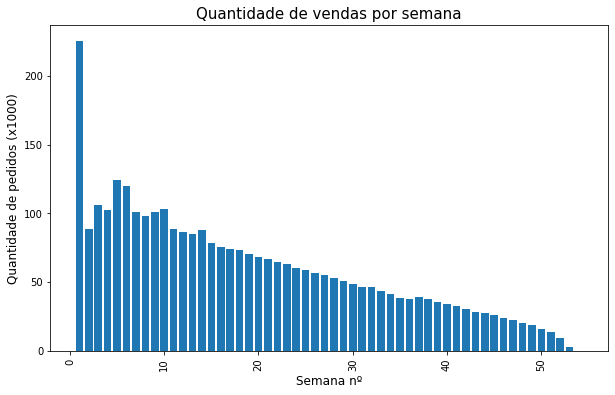

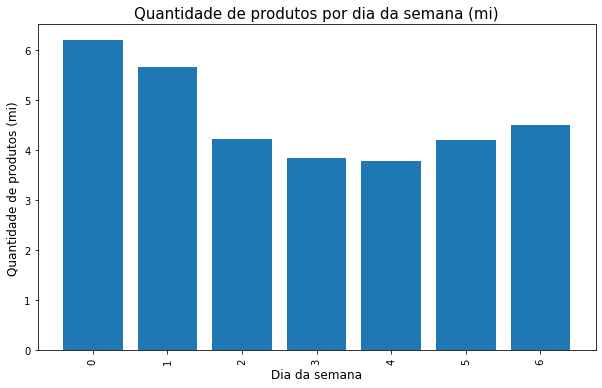

In [ ]:
# Quantidade de pedidos por semana
plt.figure(figsize=(10,6))
plt.bar(orders_week_amount.week_number,orders_week_amount.orders_amount)
plt.ylabel('Quantidade de pedidos (x1000)', fontsize=12)
plt.xlabel('Semana nº', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Quantidade de vendas por semana", fontsize=15)
plt.show()

# Quantidade de produtos por dia da semana
plt.figure(figsize=(10,6))
plt.bar(products_dow.order_dow,products_dow.products_amount)
plt.ylabel('Quantidade de produtos (mi)', fontsize=12)
plt.xlabel('Dia da semana', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Quantidade de produtos por dia da semana (mi)", fontsize=15)
plt.show()

## Qualidade de dados

## Simula comportamento diário da tabela orders

In [ ]:
## Cria tabela de amostra para estudo das colunas
amostra=100000
orders_week_sample = client.query('''
  SELECT * FROM gcp_colab_dw.orders_date where week_number between 5 and 20 limit %d
''' % (amostra)).to_dataframe()

## Obtém volumetria da tabela
stat_ref = client.query('''
  select distinct 
      cast(avg(qtd) as int64) as obs_avg,
      max(qtd) as obs_max,min(qtd) as obs_min, 
      cast(stddev(qtd) as int64) as obs_std
      ,#(select count(*) from gcp_colab_dw.orders_date) as qtd_registros
    from
  (select count(*) as qtd, order_date from gcp_colab_dw.orders_date where week_number between 5 and 20 group by order_date)
''').to_dataframe()


## Obtém estatísticas da tabela histórica (tabela exemplo)
desc_sample=orders_week_sample.describe().round().transpose()[['mean','min','max']].iloc[2:].loc[['order_number','order_dow','order_hour_of_day']]
stat_ref['qtd_colunas'] = orders_week_sample.shape[1]
stat_ref['order_number'] = [desc_sample.loc['order_number'].to_numpy().tolist()]
stat_ref['order_dow'] = [desc_sample.loc['order_dow'].to_numpy().tolist()]
stat_ref['order_hour_of_day'] = [desc_sample.loc['order_hour_of_day'].to_numpy().tolist()]
stat_ref=stat_ref.reindex(sorted(stat_ref.columns, reverse=True), axis=1)
stat_ref

,qtd_colunas,order_number,order_hour_of_day,order_dow,obs_std,obs_min,obs_max,obs_avg
0,10,"[17.0, 6.0, 99.0]","[13.0, 0.0, 23.0]","[3.0, 0.0, 6.0]",2892,8913,23029,12826


## Função para obter estatísticas da tabela diária (aleatória)

In [ ]:
## Obtém um dia aleatório para comparar com o padrão da tabela
def gera_amostra_diaria():
  global stat_orders_hj, orders_hj
  orders_hj = client.query('''
    select * from gcp_colab_dw.orders_date where order_date in (select distinct order_date from gcp_colab_dw.orders_date order by rand() limit 1);
  ''').to_dataframe()
  desc_aleatorio=orders_hj.describe().round().transpose()[['mean','min','max']].loc[['order_number','order_dow','order_hour_of_day']]
  stat_orders_hj = pd.DataFrame()
  stat_orders_hj.loc[0,'qtd_colunas'] = orders_hj.shape[1]
  stat_orders_hj.loc[0,'qtd_registros'] = orders_hj.shape[0]
  stat_orders_hj.loc[0,'data'] = orders_hj.order_date[0]
  stat_orders_hj['order_number'] = [desc_aleatorio.loc['order_number'].to_numpy().tolist()]
  stat_orders_hj['order_dow'] = [desc_aleatorio.loc['order_dow'].to_numpy().tolist()]
  stat_orders_hj['order_hour_of_day'] = [desc_aleatorio.loc['order_hour_of_day'].to_numpy().tolist()]
  stat_orders_hj.reindex(sorted(orders_hj.columns, reverse=True), axis=1)

## Função de qualidade para validar tabela diária

In [ ]:
li = []
historico_erro = pd.DataFrame(columns={'data','qtd_registros','qtd_registros_flag','qtd_colunas','qtd_colunas_flag','order_hour_of_day','order_hour_of_day_flag','order_dow','order_dow_flag'})

def valida_stats(tab_atual, stat_ref,pct):
  global historico_erro
  df_erro = pd.DataFrame(columns={'data','qtd_registros','qtd_registros_flag','qtd_colunas','qtd_colunas_flag','order_hour_of_day','order_hour_of_day_flag',         'order_dow','order_dow_flag'})  
  df_erro.loc[0,'data']=tab_atual.data.item()
  df_erro.loc[0,'qtd_colunas']=tab_atual.qtd_colunas.item()
  df_erro.loc[0,'qtd_registros']=tab_atual.qtd_registros.item()
  df_erro.loc[0,'order_hour_of_day']=tab_atual.order_hour_of_day.item()
  df_erro.loc[0,'order_dow']=tab_atual.order_dow.item()

  # Valida registros
  if (abs( (tab_atual.qtd_registros.item() - stat_ref.obs_avg.item()) / stat_ref.obs_avg.item()) >= pct):
    df_erro.loc[0,'qtd_registros_flag']=1

  # Valida quantidade de colunas
  if (tab_atual.qtd_colunas.item() != stat_ref.qtd_colunas.item()):
    df_erro.loc[0,'qtd_colunas_flag']=1

  # Valida mínimos e máximos das colunas DOW e Hour of day
  for coluna in ['order_hour_of_day','order_dow']:
    if stat_orders_hj[coluna][0][1] < stat_ref[coluna][0][1] or stat_orders_hj[coluna][0][2] > stat_ref[coluna][0][2]:
      df_erro.loc[0,coluna+'_flag']=1

  # Append do dia atual na tabela de histórico de erros
  historico_erro=historico_erro.append(df_erro, ignore_index=True).fillna(0).round(0)


## Executa função de qualidade

In [ ]:
gera_amostra_diaria()
valida_stats(stat_orders_hj,stat_ref,0.40)

print("\nTabela de estatística:\n"+stat_ref.to_string())
historico_erro.reindex(sorted(historico_erro.columns), axis=1)


Tabela de estatística:
   qtd_colunas       order_number  order_hour_of_day        order_dow  obs_std  obs_min  obs_max  obs_avg
0           10  [17.0, 6.0, 99.0]  [13.0, 0.0, 23.0]  [3.0, 0.0, 6.0]     2892     8913    23029    12826


,data,order_dow,order_dow_flag,order_hour_of_day,order_hour_of_day_flag,qtd_colunas,qtd_colunas_flag,qtd_registros,qtd_registros_flag
0,2019-11-04,"[6.0, 6.0, 6.0]",0,"[14.0, 0.0, 23.0]",0,10.0,0,13843.0,0
1,2020-09-08,"[1.0, 0.0, 6.0]",0,"[13.0, 0.0, 23.0]",0,10.0,0,3410.0,1
2,2019-11-30,"[4.0, 0.0, 6.0]",0,"[14.0, 0.0, 23.0]",0,10.0,0,13039.0,0
